# _COVID-19 X-Ray Feature Inference using Convolutional Neural Networks_

All modules used within this project are bundled with the Python Anaconda3 Library.

In [71]:
#import plotly offline to work with jupyter
import plotly.offline as pyo
pyo.init_notebook_mode()

In [181]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2 
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random

### _Create a DataFrame containing the directories and names of each image from the dataset_
_Quite self explanatory - I provide the 'basedir' which is the directory for which the images are stored (with respect to the location of the .ipynb file). Within this directory, there are three subdirectories: 'train' 'val' and 'test', each storing their respective named data. Within these folders there are a following two more subdirectories, entitled: 'NORMAL' and 'PNEUMONIA'. The DataFrame consists of two columns, 'Class' and 'Directory', which stores the class of the image (as described by the contained folder name, i.e. 'normal' or 'pneumonia'), as well as its directory._

In [248]:
#create a df containing the locations of each image and their directories
def create_dir_df():
    
    df = pd.DataFrame(columns=['Class','Directory'])
    basedir = './datasets/' 
    category = ['val','test','train']

    for choice in category:
        for folder in os.listdir(basedir+choice+'/'):
            if os.path.isdir(basedir+choice+'/'+folder):
                for Class in os.listdir(basedir+choice+'/'+folder+'/'):
                        df = df.append({'Class':folder,'Directory':basedir+choice+'/'+folder+'/'+Class},ignore_index=True)

    data_sample = df.sample(frac = 1) #Axis = 1, i.e. show a sample of the classes.
    return data_sample

df = create_dir_df()

In [249]:
print(df.shape)
df['Class'].head()

(5856, 2)


2173    PNEUMONIA
3050    PNEUMONIA
2183    PNEUMONIA
3002    PNEUMONIA
4705       NORMAL
Name: Class, dtype: object

In [250]:
print(test_df.shape)
test_df['Class'].head()

(16, 2)


9        NORMAL
0     PNEUMONIA
13       NORMAL
2     PNEUMONIA
1     PNEUMONIA
Name: Class, dtype: object

####  _Above output_
_This displays a sample of the data extracted from both the main DataFrame object and the 'test' DataFrame object, each displaying some random image classes._

### _Display some of the images from the dataset_

_Use matplotlib in order to create a figure consisting of two random (uniquely classed) images from the train dataset, each with a label above them denoting their respective class._


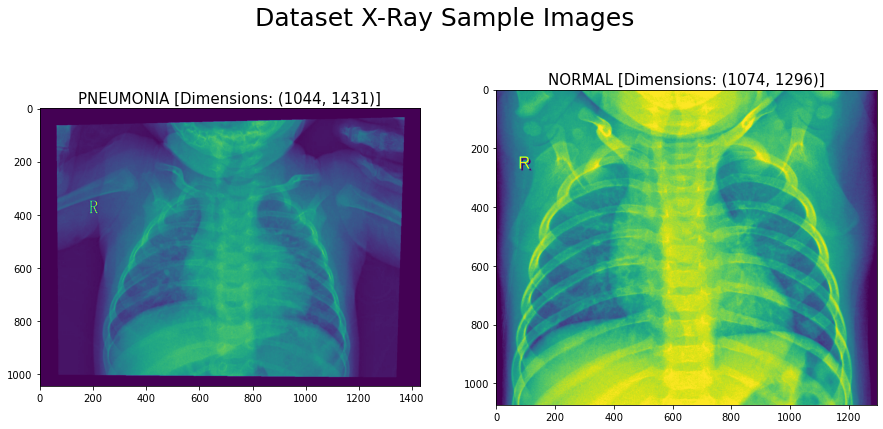

In [251]:
count = 1

f = plt.figure(figsize=(15,7))
for Class in df['Class'].unique():
    
    chosen_class = df[df['Class'] == Class] #choose an image with the given 'Class'
    
    file_location = chosen_class.sample().iloc[0]['Directory']
    img = cv2.imread(file_location,0)
    ax = f.add_subplot(1, 2, count)
    ax = plt.imshow(img)
    
    ax = plt.title(Class + ' [Dimensions: {}]'.format(img.shape), fontsize= 15) #Provide image dimensions above the image.
   
    count = count + 1
    
plt.suptitle("Dataset X-Ray Sample Images", size = 25)
plt.show()

####  _Above output_
_You can clearly see the two unique images being displayed, along with their respective image dimensions. It is evident here that the images are not all of the same size, and will therefore have to be reshaped in order to allow uniformity of data._

###  _Reshaping the images_
_Due to the uniformity of the X-Ray images, the images are all (almost) abiding by a 1:1 aspect ratio. Also, due to the nature of the scans being of the upper torso, the region of interest tends to be within the centre of the frame. I have reshaped the images using opencv and then cropped them to the centre region using the 'interpolation' parameter._

In [252]:
train_image = []
test_image = []

for location in df.iloc[:]['Directory']:
    img = cv2.imread(location,0)
    img = cv2.resize(img, (64,64), interpolation = cv2.INTER_AREA)
    img = img.reshape(64,64,1)
    train_image.append(img)
X = np.array(train_image)

###  _Data pre-processing: One-Hot Encoding_
_Since we are dealing with categorical data, it is a good idea to one-hot encode the classes. I used the in-built sklearn OneHotEncoder method in order to convert each class into a binary category._

In [253]:
#DATA TO BE USED FOR MODEL TRAINING
y = np.array(df.iloc[:]['Class'])
y = y.reshape(y.shape[0],1)
one_hot_encode = OneHotEncoder(handle_unknown='ignore') #ignore any data items that are invalid.
one_hot_encode.fit(y)
y = one_hot_encode.transform(y).toarray() #convert to numpy array in order to perform data analysis.

In [254]:
print(one_hot_encode.categories_[0])
print(y[0])

['NORMAL' 'PNEUMONIA']
[0. 1.]


####  _Above output_
_I have printed the list of categories that have been one-hot encoded. An example of an element of the 'target' or 'output' array 'y' is also listed directly below it. Here we can see that [0 1] would represent an image that has been classed as 'PNEUMONIA'._

###  _Visualising the data structure and the data itself_
_Below, I have displayed the shape of the input array X and the shape of a singular image X[0]._

__Note: I have reshaped the X[0] array to (64,64) in order to display each line of pixels as a seperate row.__

In [255]:
print('Shape of input: {}\n'.format(X.shape))
print('Shape of first image in array: \n\n{}'.format(X[0].reshape(64,64)))

Shape of input: (5856, 64, 64, 1)

Shape of first image in array: 

[[ 23  24  21 ...  44  70  90]
 [ 24  26  28 ... 116 144 128]
 [ 29  37  42 ... 117 128 118]
 ...
 [  1   0   0 ...  65  93  83]
 [  0   0   0 ...  87  68  78]
 [  0   0   0 ...   8   7  13]]


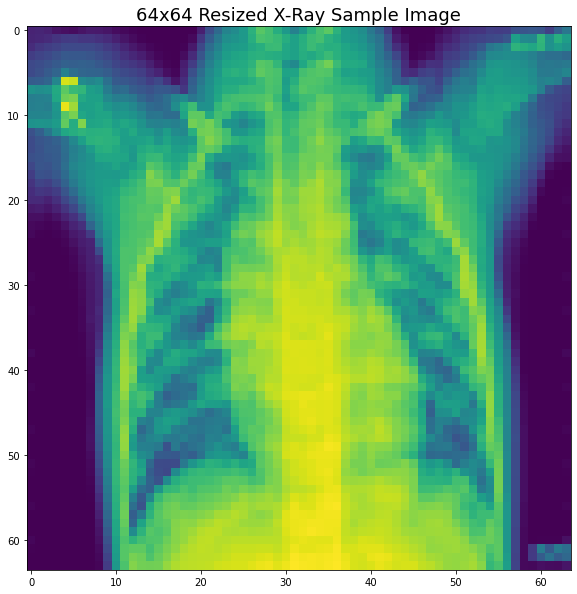

In [256]:
plt.figure(figsize=(10,10))
plt.imshow(X[0].reshape(64,64))
plt.title('64x64 Resized X-Ray Sample Image', size = 18)
plt.show()

####  _Above output_
_A plot displaying the downsampled, 64x64 image from the input array X._

###  _Data pre-processing: Splitting into Train / Test Subsets_
_Before we begin training, we must split the data in to train and test subsets. We have to do this as I collated __all__ of the data from the given default 'train' and 'test' subfolders and collated them into one, in order to attain more input data. In order to do this, we must choose a ratio. For this purpose, I have chosen a train:test split ratio of 80:20 as this is generally standardized._

In [257]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2) #20% Test Data, 80% Train Data

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4684, 64, 64, 1)
(4684, 2)
(1172, 64, 64, 1)
(1172, 2)


####  _Above output_
_The relative sizes of each of the train and test sets._

###  _Data pre-processing: Investigating Class Balance_

_Before beginning any training, I have decided to assess the balance of each class. The following code denotes the percentage of images of each class._

In [258]:
num_normal_images =  df[df['Class']== 'NORMAL'].count()[0]
num_pneu_images =  df[df['Class']== 'PNEUMONIA'].count()[0]

print('NORMAL Images: {}'.format(num_normal_images))
print('PNEUMONIA Images: {}'.format(num_pneu_images))
print('{} times more images of the PNEUMONIA class than NORMAL class.'.format((num_pneu_images/num_normal_images).round(2)))

NORMAL Images: 1583
PNEUMONIA Images: 4273
2.7 times more images of the PNEUMONIA class than NORMAL class.


####  _Above output_
_We can see the ratio of the amount of 'PNEUMONIA' images far outweighs that of the amount of 'NORMAL' images. Therefore we must correct this class imbalance._

###  _Data pre-processing: Correcting Pneumonia Class Imbalance_

_I have opted to correct this class imbalance prior to training. The following [link](http://www.chioka.in/class-imbalance-problem/) proved very useful._

In [259]:
total_train_images = X_train.shape[0]

imbalance_factor = np.log([num_pneu_images/num_normal_images])

norm_weight = (1 / num_normal_images)*(total_train_images)/2 #Inverse of amount of images * 1/2 total images 
pneu_weight = (1 / num_pneu_images)*(total_train_images)/2

class_weights = {0: norm_weight, 1: pneu_weight}

print('Weight for NORMAL class: {:.2f}'.format(norm_weight))
print('Weight for PNEUMONIA: {:.2f}'.format(pneu_weight))

Weight for NORMAL class: 1.48
Weight for PNEUMONIA: 0.55


####  _Above output_
_We can now see that the imbalance has been corrected, with a higher scaling of the NORMAL class vs. the PNEUMONIA class._

###  _Neural Network: Input and Output Shapes_
_Here is where I have defined the input shape, you can see I have sliced the first element from the X_train arrray, and this is due to the fact the 1st element denotes the number of input images, and this isn't relevant as we pass one image at a time to the network. Simiarly, the output shape is defined purely as the y_train array shape._

In [260]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape
print('Input Shape: {}'.format(input_shape))
print('Output Shape: {}'.format(output_shape))

Input Shape: (64, 64, 1)
Output Shape: (4684, 2)


###  _Neural Network: Defining Model Architecture_
_For the model architecture, due to the fact we are constructing an image based classifier, a Deep Convolutional Neural Network seemed the most appropriate model for the task. Since there are so many ways to define the structure of the network, I have designed mine from a mixture of experience as well as previous, well performing models. Since each image is relatively small in terms of dimension and contains no colour information, I was drawn to [this](https://www.pyimagesearch.com/2019/02/11/fashion-mnist-with-keras-and-deep-learning/) model for the Fashion-MNIST dataset. This network performs very well on multi-category classification, so abstracting it to binary classification with some modifications should result in good accuracy. I have changed a few items, namely I have halved the size of the Conv2D layers in order to try and decrease training time as well as decreased the kernel size on the last Conv2D layer._

In [411]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3, 3), padding="same", input_shape=input_shape))
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.BatchNormalization(axis=1))
model.add(tf.keras.layers.Conv2D(32, (3, 3), padding="same"))
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.BatchNormalization(axis=1))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(32, (3, 3), padding="same", input_shape=input_shape))
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.BatchNormalization(axis=1))

model.add(tf.keras.layers.Conv2D(32, (1, 1), padding="same"))
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.BatchNormalization(axis=1))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(2))
model.add(tf.keras.layers.Activation("softmax"))

####  _Above output_
_The above output displays the shape of each layer within the network itself._

In [439]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
activation_33 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 64, 64, 32)        256       
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
activation_34 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 64, 64, 32)        256       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 32, 32)      

####  _Above output_
_The above output displays actual structure of the network itself._

###  _Neural Network: Compiling Model_

_The network uses Categorical Crossentropy as it's loss function since we are dealing with binary, categorical data. I chose to opt for the 'adam' optimiser due to its dynamic nature and being very computationally efficient._

In [440]:
model.compile(loss="categorical_crossentropy", optimizer = 'adam', metrics=["accuracy"])

###  _Neural Network: Fitting Model_

_Here I am fitting the model with our Train and Test data. I have opted for a batch size of 32 as it provided a good medium between performance and accuracy, as well 10 epochs for training. The intent here is to develop a relatively high accuracy and low loss value in order to have the network extract features from the images in order to classify them. I intend to analyse the extracted features, rather than optimise the performance of the network as a whole. I also chose a validation split of 30% to use whilst training to validate the data._

In [414]:
history = model.fit(x = X_train, y = y_train, validation_split = 0.3, batch_size = 32, epochs = 10, class_weight = class_weights)

Epoch 1/10
103/103 [==============================] - 42s 405ms/step - loss: 0.3592 - accuracy: 0.8017 - val_loss: 16.5846 - val_accuracy: 0.2660
Epoch 2/10
103/103 [==============================] - 43s 422ms/step - loss: 0.2708 - accuracy: 0.8612 - val_loss: 0.2466 - val_accuracy: 0.9132
Epoch 3/10
103/103 [==============================] - 42s 412ms/step - loss: 0.2190 - accuracy: 0.8871 - val_loss: 0.2043 - val_accuracy: 0.9260
Epoch 4/10
103/103 [==============================] - 43s 414ms/step - loss: 0.2180 - accuracy: 0.8856 - val_loss: 0.3931 - val_accuracy: 0.8442
Epoch 5/10
103/103 [==============================] - 42s 412ms/step - loss: 0.1991 - accuracy: 0.8966 - val_loss: 0.3918 - val_accuracy: 0.8414
Epoch 6/10
103/103 [==============================] - 40s 389ms/step - loss: 0.1900 - accuracy: 0.9051 - val_loss: 0.2688 - val_accuracy: 0.8969
Epoch 7/10
103/103 [==============================] - 39s 375ms/step - loss: 0.1671 - accuracy: 0.9100 - val_loss: 0.1852 - val_a

## Overview of Results
_In general, the network seemed to perform adequately given a random test image from the dataset. Funnily, it performed much better in terms of deciding when someone did have pnuemonia, more often than it didn't! However, this is likely due to the lack of training samples, short training time and number of Epochs and no optimisation of hyperparameters. The interesting behaviour arose when visualising the outputs for the convolutional layers, which gave an insight into the types of features that the network extracted and therefore began to learn from._

###  _Objective 1 - Neural Network: Training Results_

_The network trained only for 10 Epochs with a batch size of 32 and performed surprisingly well. Below is the code and the respective plots for the Model Accuracy and Model Loss for both the training and validation sets._

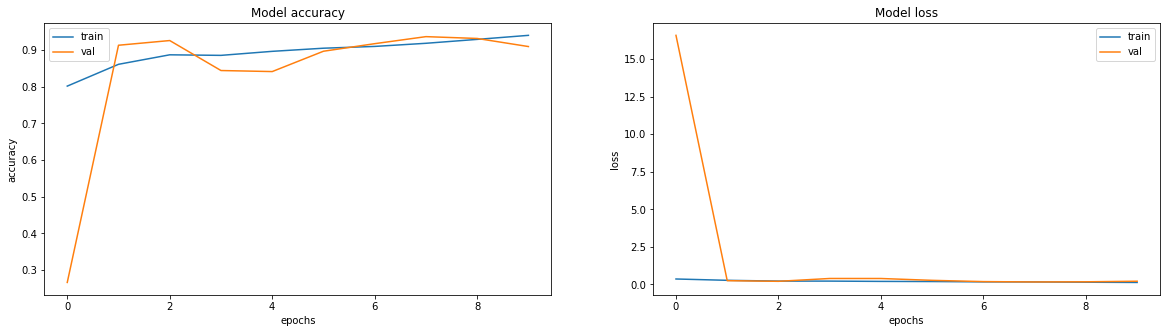

In [415]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

_As we can see here the model accuracy here approaches nearly 95% and the model loss tends toward 0 very quickly as the number of Epochs increases. This is likely due to the highly performant modified network architecture described above. This may also be due to the fact this is a realtively simple problem to model using Convolutional Layers, since we are dealing with binary classification using grayscale images, which doesn't deviate too much from that of other well researched datasets such as the aforementioned Fashion-MNIST, Omniglot or MNIST dataset._

###  _Objective 1 - Neural Network: Test Results_

_Below is the output of a variety of random images from our test set, with the correct classification, alongside the model prediction._

Text(65, 20, 'Model Value: PNEUMONIA')

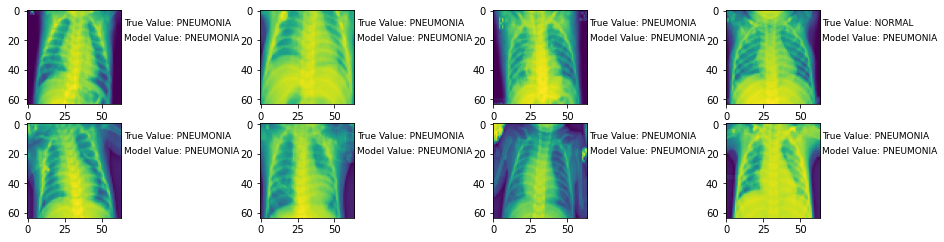

In [483]:
value = model.predict(X_test)
image_indices = np.random.randint(100, size=8)

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(4,4,1)
ax1.imshow(X_test[image_indices[0]])

ax1.text(65, 10, 'True Value: ' + enc.inverse_transform(y_test[image_indices[0]].reshape(1,2))[0][0], fontsize=9)
ax1.text(65, 20, 'Model Value: ' + enc.inverse_transform(value[image_indices[0]].reshape(1,2))[0][0], fontsize=9)
ax2 = fig.add_subplot(4,4,2)
ax2.imshow(X_test[image_indices[1]])
ax2.text(65, 10, 'True Value: ' + enc.inverse_transform(y_test[image_indices[1]].reshape(1,2))[0][0], fontsize=9)
ax2.text(65, 20, 'Model Value: ' + enc.inverse_transform(value[image_indices[1]].reshape(1,2))[0][0], fontsize=9)
ax3 = fig.add_subplot(4,4,3)
ax3.imshow(X_test[image_indices[2]])
ax3.text(65, 10, 'True Value: ' + enc.inverse_transform(y_test[image_indices[2]].reshape(1,2))[0][0], fontsize=9)
ax3.text(65, 20, 'Model Value: ' + enc.inverse_transform(value[image_indices[2]].reshape(1,2))[0][0], fontsize=9)
ax4 = fig.add_subplot(4,4,4)
ax4.imshow(X_test[image_indices[3]])
ax4.text(65, 10, 'True Value: ' + enc.inverse_transform(y_test[image_indices[3]].reshape(1,2))[0][0], fontsize=9)
ax4.text(65, 20, 'Model Value: ' + enc.inverse_transform(value[image_indices[3]].reshape(1,2))[0][0], fontsize=9)
ax5 = fig.add_subplot(4,4,5)
ax5.imshow(X_test[image_indices[4]])
ax5.text(65, 10, 'True Value: ' + enc.inverse_transform(y_test[image_indices[4]].reshape(1,2))[0][0], fontsize=9)
ax5.text(65, 20, 'Model Value: ' + enc.inverse_transform(value[image_indices[4]].reshape(1,2))[0][0], fontsize=9)
ax6 = fig.add_subplot(4,4,6)
ax6.imshow(X_test[image_indices[5]])
ax6.text(65, 10, 'True Value: ' + enc.inverse_transform(y_test[image_indices[5]].reshape(1,2))[0][0], fontsize=9)
ax6.text(65, 20, 'Model Value: ' + enc.inverse_transform(value[image_indices[5]].reshape(1,2))[0][0], fontsize=9)
ax7 = fig.add_subplot(4,4,7)
ax7.imshow(X_test[image_indices[6]])
ax7.text(65, 10, 'True Value: ' + enc.inverse_transform(y_test[image_indices[6]].reshape(1,2))[0][0], fontsize=9)
ax7.text(65, 20, 'Model Value: ' + enc.inverse_transform(value[image_indices[6]].reshape(1,2))[0][0], fontsize=9)
ax8 = fig.add_subplot(4,4,8)
ax8.imshow(X_test[image_indices[7]])
ax8.text(65, 10, 'True Value: ' + enc.inverse_transform(y_test[image_indices[7]].reshape(1,2))[0][0], fontsize=9)
ax8.text(65, 20, 'Model Value: ' + enc.inverse_transform(value[image_indices[7]].reshape(1,2))[0][0], fontsize=9)


####  _Above output_
_This displays the output of our network for the given test image. As you can see, it often correctly predicts whether a patient does indeed have pneumonia. However, upon investigation, even with class weighting, this network does not seem to predict as well if a person does not have pneumonia. This is likely due to the lack of training images, as successful classifiers tend to have tens of thousands of images to train with._

###  _Objective 2 - Neural Network: Visualising Convolutional Layer Outputs (Final Convolutional Layer)_

_The premise of this project was to assess what features a neural network uses to learn when faced with the problem of classifying patients with Pneumonia during the COVID-19 Pandemic. Below is some code that constructs a truncated model based on our model, and then allows us to extract the outputs of any respective layer and visualise them, which will potentially help us to gain insight into the diagnostic features. Here I have included the conv_layer_index value = 11, which is the 12th layer of the network, which happens to be the final Conv2D Layer._

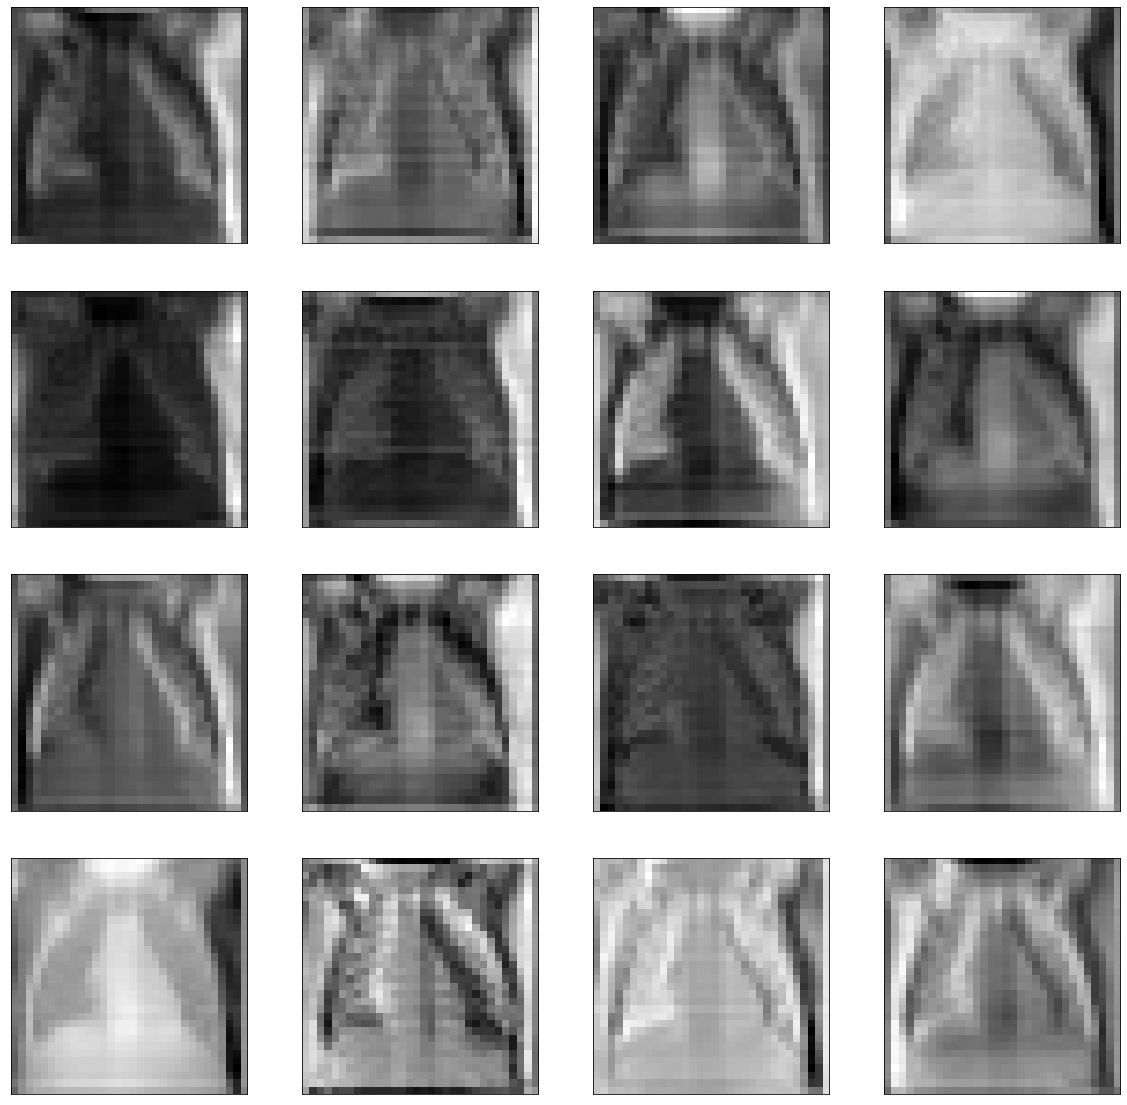

In [489]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) #Hide any tensorflow memory warning messages.

layer = model.layers 

def show_layer_output(layer_index):

    #Plot Conv2D Feature Outputs (can be used for any layer) 

    conv_layer_index = [layer_index]  #Index of a Conv2D Layer (In our case CONV2D Layers at 0 and 3... etc)
    outputs = [model.layers[i].output for i in conv_layer_index]

    model_trunc = tf.keras.Model(inputs=model.inputs, outputs=outputs)

    # Generate feature output by predicting on the input image
    feature_output = model_trunc.predict(X_test[image_index].reshape(1,64,64))

    columns = 4
    rows = 4

    for ftr in feature_output:

        fig=plt.figure(figsize=(20, 20))

        for i in range(1, columns*rows +1):
            fig =plt.subplot(rows, columns, i)
            fig.set_xticks([]) 
            fig.set_yticks([])
            plt.imshow(ftr[:, :, i-1], cmap='gray')

        plt.show()

show_layer_output(11)

####  _Above output_
_We can see from above the output for our final Conv2D Layer, there is a lack of high level detail here, predominantly due to the fact the images will have been MaxPooled and thus downsampled as they traverse through the network. However, we can start to see here that the network is looking more at the brightness / opacity of the chest. This is now starting to extract more information about the potential density of the lung fields, which may begin to constitute changes within the images for patients with pneumonia._

###  _Objective 2 - Neural Network: Visualising Convolutional Layer Outputs (First Convolutional Layer)_

_In contrast, here is a sample from the first convolutional layer:_

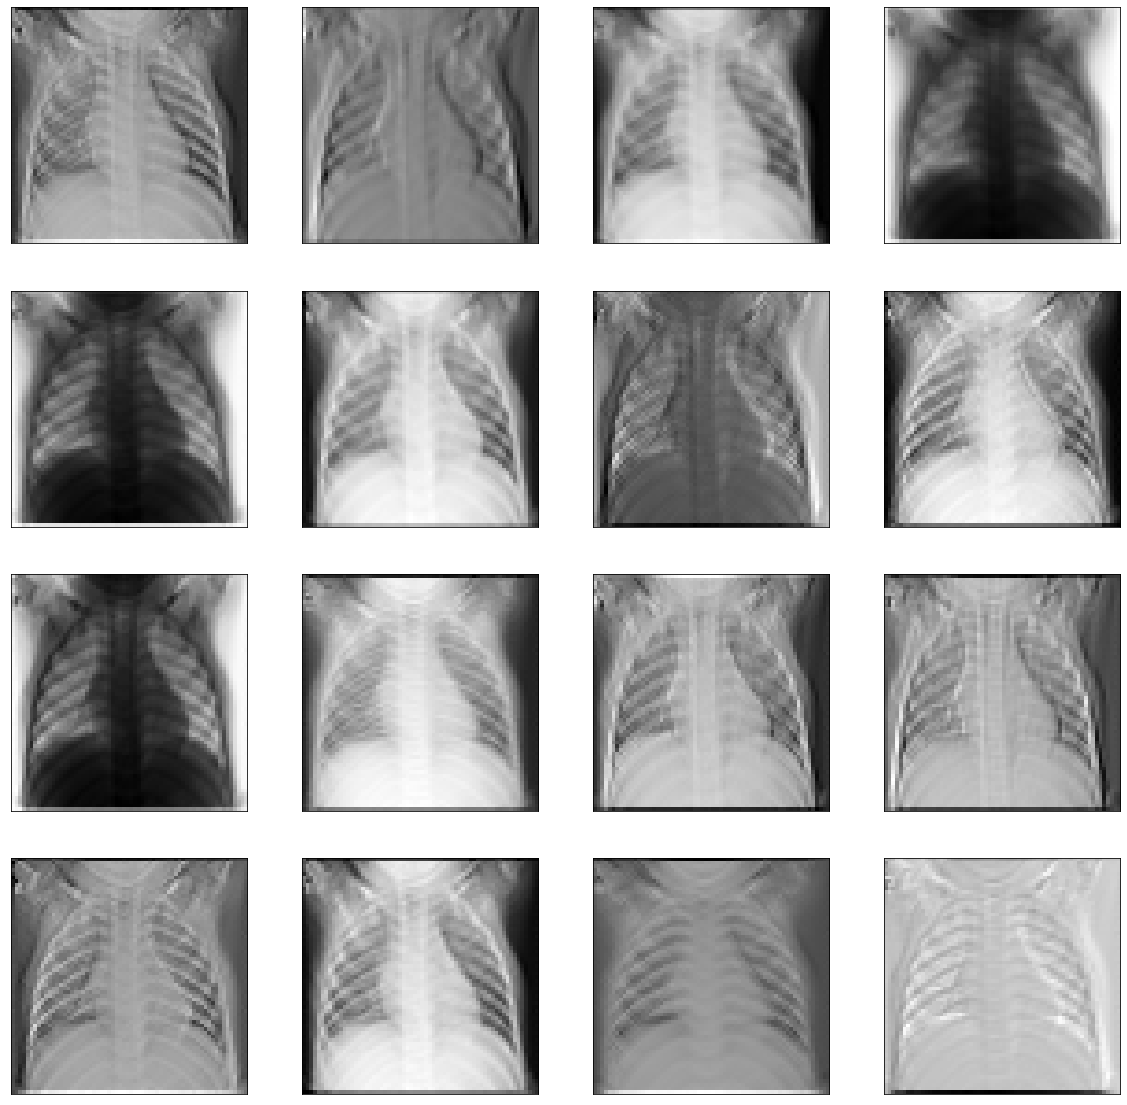

In [491]:
show_layer_output(0)

####  _Above output_
_We can see from above the output for our first Conv2D Layer, there is evidently much more high level detail here, denoting the contours of the ribs, the complex structures of the chest along with edges that are sharply defined. Likely what is happening here is the convolutional layer is detecting edges and areas of sharp contrast._

# Concluding Remarks

### Acheivements
_The network model itself tends to perform averagely with little training (however this may be slightly biased based on the input data being slightly skewed) but managed to predict the majority of classes with relative ease. Having said this, the main aim of the project was to analyse some of the convolutional layer outputs, which resulted in overall network optimisation being deemed less important. We were also able to infer some information about how the network is actually classifying the images, which allowed us to hypothesise that the denser / darker areas of the image denote areas within the lungs that are likely more filled with air / fluid, which could constitute a diagnosis of pneumonia. Further to this, the network began to show that it was disregarding information about the edges / contours of the ribs and starting to look at the luminosity and denisty of the actual lung fields themselves. This provided us with a good insight as to what (artificial) diagnostic criteria could be beneificial in diagnosing patients._

### Limitations

_The project was unfortunately limited by the number of images available for training. Because of this, I fear the model may have overfit slightly or underperformed on unseen data, due to a lack of images - even though theoretically the model performs well. Further to this, the large class imbalance may have lead to potential bias when classifying images._

### Future Work

_In future, given more time, it would have been beneficial to tune the network structure and hyperparameter in order to optimise the training loss. It would have also been useful to analyse different metrics in order to truly investigate the raw performance of the network, even though this was not the primary aim of this study. Further to this, acquring data from a variety of datasets and manually cleaning / combining them would have allowed training on a larger variety and quantity of images, which would have likely impacted the training performance._